In [34]:
import os
import sys
from datetime import datetime
import keras
import skimage.io as io 

import argparse
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
# get_ipython().run_line_magic('matplotlib', 'inline')

from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Adamax
import keras.backend as K

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from func import * 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/

In [2]:
#### parser
parser = argparse.ArgumentParser()
parser.add_argument('-s' ,'--model_save', type=str, default='/home/katieyth/gynecology/model_save/', help='model save path')
parser.add_argument('-y' ,'--target', type=str, default='multi', help='prediction target')
parser.add_argument('-cv_path' ,'--cv_path', type=str, default='/home/katieyth/gynecology/data/5_fold_CMU_rs_13/', help='cv_path')

 
# input parameter
parser.add_argument('-th','--acceptable_zeros_threshold', type=float, default=200, help='acceptable number of missing values in raw data')
parser.add_argument('-l' ,'--length', type=int, default=600, help='length of input')
parser.add_argument('-ks','--k_slice', type=int, default=1, help='a input will be sliced into k_slice segments when testing')
parser.add_argument('-c' ,'--n_channel', type=int, default=2, help='number of input channels')
parser.add_argument('-rn','--random_noise', type=int, default=0, help='add Gaussian noise (mean=0, std=0.01) into inputs')
parser.add_argument('-nm','--normalized', type=int, default=1, help='whether conduct channel-wise normalization')

# data augmentation 
parser.add_argument('-aug_fliplr' ,'--aug_fliplr', type=int, default=0, help='reverse time series')
parser.add_argument('-shift' ,'--DA_Shift', type=int, default=1, help='')
parser.add_argument('-scale' ,'--DA_Scale', type=int, default=1, help='')
parser.add_argument('-randsamp' ,'--DA_RandSampling', type=int, default=1, help='')


# model parameters
parser.add_argument('-struc' ,'--struc', type=str, default='mimic_previous_FHB', help='deeper or shallower')
parser.add_argument('-k' ,'--kernel_size', type=int, default=3, help='kernel size')
parser.add_argument('-f' ,'--filters', type=int, default=64, help='base number of filters')
parser.add_argument('-ly' ,'--layers', type=int, default=5, help='number of residual layers')
parser.add_argument('-a' ,'--activation', type=str, default='relu', help='activation function')
parser.add_argument('-i' ,'--kernel_initializer', type=str, default='RandomNormal', help='kernel initialization method')
parser.add_argument('-l2','--l2', type=float, default=0.01, help='coefficient of l2 regularization')

# hyper-parameters
parser.add_argument('-lr','--learning_rate', type=float, default=1e-4, help='learning_rate')
parser.add_argument('-reduce_lr_patience','--reduce_lr_patience', type=int, default=50, help='reduce_lr_patience')
parser.add_argument('-bs','--batch_size', type=int, default=27, help='batch_size')
parser.add_argument('-ep','--epoch', type=int, default=15, help='epoch')
parser.add_argument('-wb','--weight_balance', type=int, default=1, help='whether weight balancing or not')
parser.add_argument('-mntr','--monitor', type=str, default='val_man_acc', help='val_acc or val_loss')

parser.add_argument('-g' ,'--gpu_id', type=str, default='2', help='GPU ID')
parser.add_argument('-fd' ,'--fold', type=int, default=1, help='CMU_5_fold')
parser.add_argument('-fn' ,'--summary_file', type=str, default='', help='summary filename')

FLAG = parser.parse_args([])
os.environ['CUDA_VISIBLE_DEVICES'] = FLAG.gpu_id

# Data prepare

In [3]:
def data_preprocess_test(Xvalid, Yvalid, length=600):
    Xtest = np.empty((Xvalid.shape[0], length, Xvalid.shape[2]))
    for i in range(Xvalid.shape[0]):
        Xtest[i,:,:] = data_normalize(Xvalid[i,0:600,:])
    Ytest = Yvalid.copy()
    return Xtest, Ytest

In [4]:
### data preparing
train_d = pd.read_csv(os.path.join(FLAG.cv_path, '5_fold_0%s_train.csv' %(FLAG.fold)))
valid_d = pd.read_csv(os.path.join(FLAG.cv_path, '5_fold_0%s_test.csv' %(FLAG.fold)))

# replace 0 (no readings) with np.nan for later substitution
for k in train_d.columns:
    if 'b-' in k or 'm-' in k:
        print(k, end='\r')
        train_d.loc[train_d[k]==0, k] = np.nan
for k in valid_d.columns:
    if 'b-' in k or 'm-' in k:
        print(k, end='\r')
        valid_d.loc[valid_d[k]==0, k] = np.nan

    
# interpolate missing values
train_db = np.array(train_d[[k for k in train_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
train_dm = np.array(train_d[[k for k in train_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
valid_db = np.array(valid_d[[k for k in valid_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
valid_dm = np.array(valid_d[[k for k in valid_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
# combine signals from baby and mom
Xtrain = np.stack([train_db, train_dm], axis=2)
Xvalid = np.stack([valid_db, valid_dm], axis=2)

# convert labels to one-hot encodings
target_list = ['management', 'UA', 'variability', 'deceleration', 'FHB_class', 'management']
target_dict = {'management':3,
               'UA':2,
               'variability':2,
               'deceleration':4,
               'FHB_class':4,
               'management':3}
Ytrain = [(keras.utils.to_categorical(np.array(train_d[c_name]),num_classes=target_dict[c_name])) for c_name in target_list]
Yvalid = [(keras.utils.to_categorical(np.array(valid_d[c_name]),num_classes=target_dict[c_name])) for c_name in target_list]

#weight balancing or not
if FLAG.weight_balance:
    weight_list = []
    for idx, c_name in enumerate(target_list):
        y_integers = np.argmax(Ytrain[idx], axis=1)
        d_class_weight = compute_class_weight('balanced', np.unique(y_integers), y_integers)
        class_weight = dict(enumerate(d_class_weight))
        print('class weight: {0}'.format(class_weight))
        weight_list.append(class_weight)
else:
    weight_list = []
    for idx, c_name in enumerate(target_list):
        class_weight = dict()
        for i in range(target_dict[c_name]):
            class_weight[i] = 1
        print('class weight: {0}'.format(class_weight))
        weight_list.append(class_weight)

Xtest, Ytest =data_preprocess_test(Xvalid, Yvalid)


if FLAG.aug_fliplr:
    Xtrain_copy = Xtrain.copy()
    for i in range(len(Xtrain)):
        Xtrain_copy[i] = np.fliplr([Xtrain[i]])[0]
        print(i,'/',len(Xtrain), end= '\r')
    Xtrain = np.vstack((Xtrain, Xtrain_copy))
    Ytrain = np.vstack((Ytrain, Ytrain))

print('train:', len(train_d))
print('test:', len(valid_d))

class weight: {0: 0.5142857142857142, 1: 1.0384615384615385, 2: 10.8}
class weight: {0: 5.4, 1: 0.5510204081632653}
class weight: {0: 0.5664335664335665, 1: 4.2631578947368425}
class weight: {0: 0.4308510638297872, 1: 1.9285714285714286, 2: 0.9, 3: 20.25}
class weight: {0: 0.50625, 1: 40.5}
class weight: {0: 0.5142857142857142, 1: 1.0384615384615385, 2: 10.8}
train: 162
test: 45


# Define func

In [24]:
# get gradient
def get_grad(model, model_pred, tg_position, grad_layer):
    '''get_grad(model = trained_model,
                model_pred = pred,
                tg_position = tg_dict[tg],
                grad_layer = 'conv1d_25') '''
    prd_cls = np.argmax(pred[tg_position], axis = 1)
    # 只有一個dim，所以取0那個dim，再指定 model 預測的 class (不是 G-true label)
    y_c = model.output[tg_position][0,prd_cls]
    # 選最後一個 conv layer 作為要取 gradient 的位置
    conv_layer = model.get_layer(grad_layer).output
    # tf.gradients()
    grads = K.gradients(y_c, conv_layer)[0]
    gradient_function = K.function([model.input], [conv_layer, grads])
    ###### flow to the graph and get *target layer and * corresponding gradient
    conv_output, grads_val = gradient_function([ctg_x])
    
    return conv_output, grads_val

In [25]:
# follow paper method (Grad-CAM)
def GCAM(feature_map, Fmap_grad):
    '''GCAM(feature_map = conv_output,
            Fmap_grad = grads_val)'''
    ### (1,10,192) feature map size: (1,10) feature map num: 192 
    ### get mean gradients for each feature map as its weight
    weights = np.mean(Fmap_grad, axis = (0, 1))
    ### multiply each F_map by its corresponding weight
    for i, w in enumerate(weights):  
            feature_map[:, :, i] *= w 
    ### sum each feature point by point to get 'global weight' (1:10) 
    hightlight_fmap = np.sum(feature_map, axis=2)
    ### passing relu, we only concern those with positive reponse to model's prediction
    hightlight_fmap_relu = np.maximum(hightlight_fmap, 0) 
    
    
    return hightlight_fmap_relu[0]

In [26]:
# get material for visualizing 1D Grad-CAM
def get_material_vis_by_tg(model, tg_position, pred):
    ''' get_material_vis_by_tg(model = trained_model,
                               tg_position = tg_dict[tg],
                               pred = pred)'''
    conv_output, grads_val = get_grad(model = model,
                                  model_pred = pred,
                                  tg_position = tg_position,
                                  grad_layer = 'conv1d_25')
    hightlight_fmap_relu = GCAM(feature_map = conv_output,
                                Fmap_grad = grads_val)
#     HL_extend = np.repeat(hightlight_fmap_relu, 60)
#     HL_extend = np.expand_dims(HL_extend, axis = 0)
    x_axis = [i for i in range(600)]
    
    return x_axis, hightlight_fmap_relu

In [27]:
# create grid: 4 2-pairs
def create_grid():
    n = 4 # number of double-rows
    m = 1 # number of columns

    t = 0.9 # 1-t == top space 
    b = 0.1 # bottom space      (both in figure coordinates)

    msp = 0.1 # minor spacing
    sp = 0.5  # major spacing

    offs=(1+msp)*(t-b)/(2*n+n*msp+(n-1)*sp) # grid offset
    hspace = sp+msp+1 #height space per grid

    gso = GridSpec(n,m, bottom=b+offs, top=t, hspace=hspace)
    gse = GridSpec(n,m, bottom=b, top=t-offs, hspace=hspace)

    fig = plt.figure(figsize=(10,6))
    axes1 = []
    axes2 = []
    for i in range(n*m):
        axes1.append(fig.add_subplot(gso[i]))
        axes2.append(fig.add_subplot(gse[i]))
    return fig, axes1, axes2

# Visulize 1D Grad-CAM

In [9]:
tg_dict = {'man':0,
          'ua':1,
          'var':2,
          'dec':3}
tg_list = ['Management',
          'UA',
          'Variability',
          'Deceleration']

In [10]:
model_pstn = 'model_save/multi/multi_190118211950/' 
model_path = os.path.join('/home/katieyth/gynecology/', model_pstn)
trained_model = load_model(os.path.join(model_path,'model.h5'))


deal_Xset = Xtest
deal_Yset = Ytest
deal_ID = valid_d.ID
save_dir = os.path.join(model_pstn, 'GCAM_1D/test_conv25')

## test model performance_D

In [38]:
trained_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 600, 2)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 600, 64)      448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 600, 64)      256         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 600, 64)      0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv1d_2 (

management accuracy :  0.9333333333333333
management_recall-0 : 1.0000
management_recall-1 : 0.8667
management_recall-2 : 0.5000
management_recall-average : 0.7889
management_precision-0: 0.9655
management_precision-1: 0.9286
management_precision-2: 0.5000
management_precision-average : 0.7980
management_F1-0: 0.9825
management_F1-1: 0.8966
management_F1-2: 0.5000
management_F1-average : 0.7930
Confusion matrix, without normalization
[[28  0  0]
 [ 1 13  1]
 [ 0  1  1]]
UA accuracy :  0.8666666666666667
UA_recall-0 : 0.8000
UA_recall-1 : 0.8750
UA_recall-average : 0.8375
UA_precision-0: 0.4444
UA_precision-1: 0.9722
UA_precision-average : 0.7083
UA_F1-0: 0.5714
UA_F1-1: 0.9211
UA_F1-average : 0.7462
Confusion matrix, without normalization
[[ 4  1]
 [ 5 35]]
variability accuracy :  0.9111111111111111
variability_recall-0 : 0.9250
variability_recall-1 : 0.8000
variability_recall-average : 0.8625
variability_precision-0: 0.9737
variability_precision-1: 0.5714
variability_precision-average

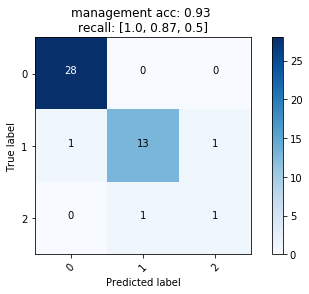

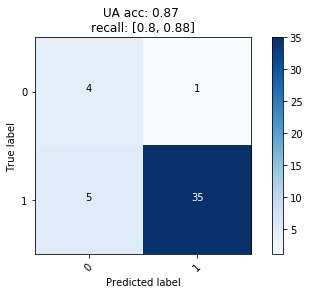

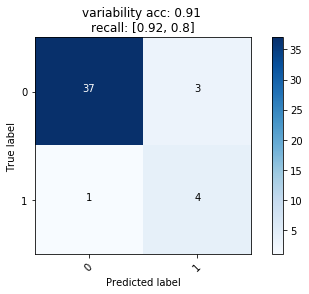

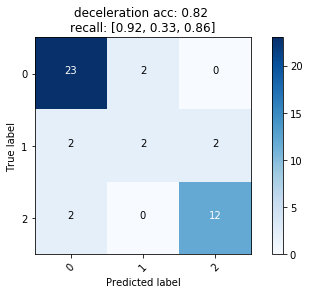

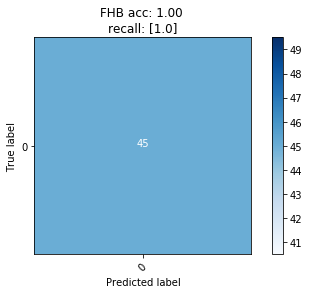

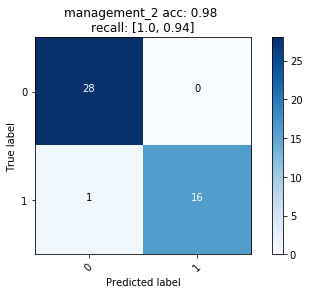

In [22]:
# Pred = trained_model.predict(deal_Xset)
# c_list = ['management', 'UA', 'variability', 'deceleration', 'FHB',]
# for c in range(len(c_list)):
#     ypred_aug = np.argmax(Pred[c] , axis=1)
#     ytest_aug = np.argmax(Ytest[c], axis=1)

#     cfm = confusion_matrix(y_pred=ypred_aug, y_true=ytest_aug)
#     recall = np.diag(cfm) / np.sum(cfm, axis=1)
#     precision = np.diag(cfm) / np.sum(cfm, axis=0)
#     val_accu = accuracy_score(y_pred=ypred_aug, y_true=ytest_aug)
#     f1 = f1_score(y_pred=ypred_aug, y_true=ytest_aug, average=None)
#     print('%s accuracy : ' % (c_list[c]), val_accu)
#     tmp_list = []
#     for i in range(len(recall)):
#         print('%s_recall-%d : %.4f' %(c_list[c],i, recall[i]))
#         tmp_list.append(recall[i])
#     print('%s_recall-average : %.4f' %(c_list[c], sum(tmp_list)/len(tmp_list)))
    
#     tmp_list = []
#     for i in range(len(precision)):
#         print('%s_precision-%d: %.4f' % (c_list[c],i, precision[i]))
#         tmp_list.append(precision[i])
#     print('%s_precision-average : %.4f' %(c_list[c], sum(tmp_list)/len(tmp_list)))
    
#     tmp_list = []
#     for i in range(len(f1)):
#         print('%s_F1-%d: %.4f' % (c_list[c],i, f1[i]))
#         tmp_list.append(f1[i])
#     print('%s_F1-average : %.4f' %(c_list[c], sum(tmp_list)/len(tmp_list)))
    

#     plt.figure()
#     rcl = [round(recall[i],2) for i in range(len(recall))]
#     plot_confusion_matrix(cfm, classes=np.arange(len(recall)),
#                           title='%s acc: %.2f \nrecall: %s' %(c_list[c], val_accu,rcl),
#                           save_dir='')
# # force management to 2 label 
# c_list = ['management_2']
# for idx, c in enumerate([0]):
#     # evaluate by every segment
#     ypred_aug = np.argmax(Pred[c] , axis=1)
#     ytest_aug = np.argmax(Ytest[c], axis=1)
#     ypred_aug[ypred_aug>1]=1
#     ytest_aug[ytest_aug>1]=1

#     cfm = confusion_matrix(y_pred=ypred_aug, y_true=ytest_aug)
#     recall = np.diag(cfm) / np.sum(cfm, axis=1)
#     precision = np.diag(cfm) / np.sum(cfm, axis=0)
#     val_accu = accuracy_score(y_pred=ypred_aug, y_true=ytest_aug)
#     f1 = f1_score(y_pred=ypred_aug, y_true=ytest_aug, average=None)
    
#     tmp_list = []
#     for i in range(len(recall)):
#         print('%s_recall-%d : %.4f' %(c_list[idx],i, recall[i]))
#         tmp_list.append(recall[i])
#     print('%s_recall-average : %.4f' %(c_list[idx], sum(tmp_list)/len(tmp_list)))
    
#     tmp_list = []
#     for i in range(len(precision)):
#         print('%s_precision-%d: %.4f' % (c_list[idx],i, precision[i]))
#         tmp_list.append(precision[i])
#     print('%s_precision-average : %.4f' %(c_list[idx], sum(tmp_list)/len(tmp_list)))
    
#     tmp_list = []
#     for i in range(len(f1)):
#         print('%s_F1-%d: %.4f' % (c_list[idx],i, f1[i]))
#         tmp_list.append(f1[i])
#     print('%s_F1-average : %.4f' %(c_list[idx], sum(tmp_list)/len(tmp_list)))
    

#     plt.figure()
#     rcl = [round(recall[i],2) for i in range(len(recall))]
#     plot_confusion_matrix(cfm, classes=np.arange(len(recall)), 
#                           title='%s acc: %.2f \nrecall: %s' %(c_list[idx], val_accu,rcl),
#                           save_dir='' )
  

# Start 

In [ ]:
# kk = np.expand_dims(hightlight_fmap_relu, axis=0)
# plt.imshow(kk, cmap = 'coolwarm')
# plt.axis('off')

In [45]:
for idx, ID in enumerate(deal_ID):
# for idx, ID in enumerate(deal_ID[0:1]):
    ctg_x = np.expand_dims(deal_Xset[idx], axis=0)

    ctg_y_man = np.argmax(deal_Yset[0][idx])
    ctg_y_ua  = np.argmax(deal_Yset[1][idx])
    ctg_y_var = np.argmax(deal_Yset[2][idx])
    ctg_y_dec = np.argmax(deal_Yset[3][idx])
    ctg_y = [deal_Yset[0][idx],
             deal_Yset[1][idx],
             deal_Yset[2][idx],
             deal_Yset[3][idx]]
    pred = trained_model.predict(ctg_x)
    
    fig, axes1, axes2 = create_grid()
    for od, tg_name in enumerate(['man', 'ua', 'var', 'dec']):
        x_axis, hightlight_fmap_relu \
        = get_material_vis_by_tg(model = trained_model,
                                 tg_position = tg_dict[tg_name],
                                 pred = pred)
###############只秀最後的小 feature map###########################################
#         plt.close(fig)
#         kk = np.expand_dims(hightlight_fmap_relu, axis=0)
#         plt.imshow(kk, cmap = 'coolwarm')
#         plt.axis('off')
#         plt.show()
#################################################################       
        
        pred_prob = [int(v*100) for v in pred[od][0]]
        true_prob = [int(v) for v in ctg_y[od]]


        ax = axes1[od]
        for i in range(len(hightlight_fmap_relu)):
            local_max = max(hightlight_fmap_relu) # temporary, should get global max in the future (?)
            ax.plot(x_axis[i*60:(i+1)*60],
                     ctg_x[0][i*60:(i+1)*60,0], # baby
                     color = cm.coolwarm(hightlight_fmap_relu[i]/local_max))
        ax.set_xticks([], [])
        ax.set_yticks([], [])
        if tg_name == 'man':
            ax.set_title('◉  '+tg_list[od] + '    #ID: %s' %(ID), x = 0, loc = 'left')
        else:
            ax.set_title('◉  '+tg_list[od], x = 0, loc = 'left')
        
        ax.yaxis.set_label_position("right")
        ax.set_ylabel('True Label\n  %s\n'%(true_prob)+\
                      'Model Confidence (%)'+'\n  %s' %(pred_prob),
                      fontsize=10, rotation = 0,
                      horizontalalignment='left',
                      position=(0,1))


        ax = axes2[od]
        for i in range(len(hightlight_fmap_relu)):
            local_max = max(hightlight_fmap_relu) # temporary, should get global max in the future (?)
            ax.plot(x_axis[i*60:(i+1)*60],
                    ctg_x[0][i*60:(i+1)*60,1], # mommy
                    color = cm.coolwarm(hightlight_fmap_relu[i]/local_max))
        ax.set_xticks([], [])
        ax.set_yticks([], [])

    check_dir(save_dir)
    fig.savefig(os.path.join(save_dir, '%s.png' % (ID)), dpi=150, bbox_inches='tight')
    plt.close(fig)
    print( '%d/%d' %(idx, len(deal_Xset)), end='\r')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in float_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in float_scalars


# annotate color bar ( Not REQUIRED )

In [46]:
deal_p = os.listdir(save_dir)
c_bar = io.imread('./Screenshot from 2019-01-09 15-03-40.png')
for idx, fname in enumerate(deal_p):
    fig2 = plt.figure(figsize=(10,6), dpi = 200)
    outer_grid = GridSpec(2,1, height_ratios=[1, 20],
                         hspace=0)
    ax0 = fig2.add_subplot(outer_grid[0])

    ax0.annotate('⇦ Lower Response', xy=(200,23), xytext=(20, 23), size = 8, color= 'white')
    ax0.annotate('Higher Response ⇨', xy=(200,23), xytext=(400, 23), size = 8, color= 'white')
    ax0.imshow(c_bar[:31,:,:])
    ax0.axis('off')

    ax1 = fig2.add_subplot(outer_grid[1])
    p_signal = io.imread(os.path.join(save_dir, fname))
    ax1.imshow(p_signal[10:,10:,:])
    ax1.axis('off')
    fig2.savefig(os.path.join(save_dir, fname), dpi=200, bbox_inches='tight')
    plt.close(fig2)
    print( '%d/%d' %(idx, len(deal_p)), end='\r')